<a href="https://colab.research.google.com/github/christianbammann/introtoML/blob/main/homework6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
from google.colab import drive

from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, log_loss
)
from sklearn import metrics

# **Problem 1**

In [125]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/diabetes.csv")
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [126]:
X = df.iloc[:, 0:8].values
Y = df.iloc[:, 8].values

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.20, random_state=0
)

In [132]:
print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Training samples: 614
Test samples: 154


In [133]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test  = sc_X.transform(X_test)
print("Train mean (first 5):", X_train.mean(axis=0)[:5])
print("Train std  (first 5):", X_train.std(axis=0, ddof=0)[:5])

Train mean (first 5): [-3.55307531e-17  7.14231425e-18  1.90039804e-16  5.20756077e-17
  2.89670568e-16]
Train std  (first 5): [1. 1. 1. 1. 1.]


In [130]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, Y_train)

LogisticRegression(random_state=0)

In [10]:
Y_pred = classifier.predict(X_test)

In [11]:
Y_pred[0:9]

array([1, 0, 0, 1, 0, 0, 1, 1, 0])

In [12]:
print("Predictions (first 10):", Y_pred[:10])
print("Actual (first 10):     ", Y_test[:10])

Predictions (first 10): [1 0 0 1 0 0 1 1 0 0]
Actual (first 10):      [1 0 0 1 0 0 1 1 0 0]


In [15]:
# Logistic Regression Model
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("Precision:",metrics.precision_score(Y_test, Y_pred))
print("Recall:",metrics.recall_score(Y_test, Y_pred))
print("F1 Score:", metrics.f1_score(Y_test, Y_pred))

Accuracy: 0.8246753246753247
Precision: 0.7631578947368421
Recall: 0.6170212765957447
F1 Score: 0.6823529411764706


In [134]:
# SVM Model
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
svm_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="linear", C=1.0))
])

svm_linear.fit(X_train, Y_train)
y_pred = svm_linear.predict(X_test)

In [135]:
acc = accuracy_score(Y_test, y_pred)
pre = precision_score(Y_test, y_pred)
rec = recall_score(Y_test, y_pred)

print("SVM:")
print("Accuracy:", metrics.accuracy_score(Y_test, y_pred))
print("Precision:", metrics.precision_score(Y_test, y_pred))
print("Recall:", metrics.recall_score(Y_test, y_pred))
print("F1 Score:", metrics.f1_score(Y_test, y_pred))

SVM:
Accuracy: 0.8246753246753247
Precision: 0.7631578947368421
Recall: 0.6170212765957447
F1 Score: 0.6823529411764706


### **1c. Neural Network**

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

In [67]:
X = df.drop("Outcome", axis=1).values
y = df["Outcome"].values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (768, 8)
y shape: (768,)


In [87]:
X_train, X_val, y_train_np, y_val_np = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)

X_train_scaled shape: (614, 8)
X_val_scaled shape: (154, 8)


In [88]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)

y_train_t = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
y_val_t   = torch.tensor(y_val_np,   dtype=torch.float32).view(-1, 1)

In [89]:
class DiabetesFCNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)   # direct to output
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)  # raw logits

In [90]:
input_dim = X_train_t.shape[1]
model = DiabetesFCNN(input_dim)

In [95]:
pos_weight = torch.tensor([2.0])
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=0.00008)

In [96]:
def train_loop(model, X_train, y_train, X_val, y_val, loss_fn, optimizer, epochs=200):
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        # training
        model.train()
        logits = model(X_train)
        loss_train = loss_fn(logits, y_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            loss_val = loss_fn(val_logits, y_val)

        train_losses.append(loss_train.item())
        val_losses.append(loss_val.item())

        if epoch == 1 or epoch % 20 == 0:
            print(f"Epoch {epoch}: train={loss_train.item():.4f}, val={loss_val.item():.4f}")

    return train_losses, val_losses

train_losses, val_losses = train_loop(
    model, X_train_t, y_train_t, X_val_t, y_val_t,
    loss_fn, optimizer, epochs=400
)

Epoch 1: train=0.9116, val=0.9297
Epoch 20: train=0.9086, val=0.9271
Epoch 40: train=0.9056, val=0.9245
Epoch 60: train=0.9026, val=0.9220
Epoch 80: train=0.8996, val=0.9195
Epoch 100: train=0.8966, val=0.9171
Epoch 120: train=0.8937, val=0.9147
Epoch 140: train=0.8908, val=0.9122
Epoch 160: train=0.8878, val=0.9098
Epoch 180: train=0.8849, val=0.9074
Epoch 200: train=0.8820, val=0.9050
Epoch 220: train=0.8792, val=0.9026
Epoch 240: train=0.8763, val=0.9003
Epoch 260: train=0.8734, val=0.8979
Epoch 280: train=0.8705, val=0.8956
Epoch 300: train=0.8677, val=0.8932
Epoch 320: train=0.8648, val=0.8909
Epoch 340: train=0.8620, val=0.8886
Epoch 360: train=0.8591, val=0.8863
Epoch 380: train=0.8563, val=0.8839
Epoch 400: train=0.8535, val=0.8816


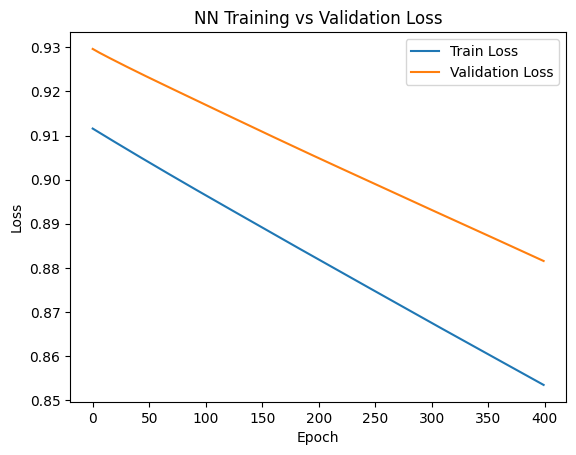

In [97]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("NN Training vs Validation Loss")
plt.legend()
plt.show()

In [98]:
model.eval()
with torch.no_grad():
    logits = model(X_val_t)
    probs = torch.sigmoid(logits)
    y_pred = (probs > 0.5).int().numpy().flatten()

nn_acc  = accuracy_score(y_val_np, y_pred)
nn_prec = precision_score(y_val_np, y_pred)
nn_rec  = recall_score(y_val_np, y_pred)
nn_f1   = f1_score(y_val_np, y_pred)

print("Neural Network:")
print("Accuracy:", nn_acc)
print("Precision:", nn_prec)
print("Recall:", nn_rec)
print("F1 Score:", nn_f1)

Neural Network:
Accuracy: 0.512987012987013
Precision: 0.41732283464566927
Recall: 0.9814814814814815
F1 Score: 0.585635359116022


# **Problem 2**

### **2a. Logistic Regression**
### **2b. SVM**

In [136]:
from sklearn.datasets import load_breast_cancer

In [137]:
cdata = load_breast_cancer()
df = pd.DataFrame(cdata.data, columns=cdata.feature_names)
df['target'] = cdata.target
df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [138]:
X = df.iloc[:, 0:30].values
Y = df.iloc[:, 30].values

In [139]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.20, random_state=0, stratify=Y
)

print("Training samples:", X_train.shape[0])
print("Test samples    :", X_test.shape[0])

print("Positive rate (train):", Y_train.mean())
print("Positive rate (test) :", Y_test.mean())

Training samples: 455
Test samples    : 114
Positive rate (train): 0.6263736263736264
Positive rate (test) : 0.631578947368421


In [140]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test  = sc_X.transform(X_test)
print("Train mean (first 5):", X_train.mean(axis=0)[:5])
print("Train std  (first 5):", X_train.std(axis=0, ddof=0)[:5])

Train mean (first 5): [-2.86803548e-15 -2.99491811e-15  2.42101821e-15  8.36937357e-16
  1.17024827e-15]
Train std  (first 5): [1. 1. 1. 1. 1.]


In [141]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, Y_train)

LogisticRegression(random_state=0)

In [142]:
Y_pred = classifier.predict(X_test)

In [143]:
Y_pred[:10]

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0])

In [144]:
print("Predictions (first 10):", Y_pred[:10])
print("Actual (first 10):     ", Y_test[:10])

Predictions (first 10): [0 0 0 1 0 1 0 1 1 0]
Actual (first 10):      [0 0 0 1 0 1 0 1 1 0]


In [145]:
# Logistic Regression Model
print("Logistic Regression:")
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("Precision:",metrics.precision_score(Y_test, Y_pred))
print("Recall:",metrics.recall_score(Y_test, Y_pred))
print("F1 Score:", metrics.f1_score(Y_test, Y_pred))

Logistic Regression:
Accuracy: 0.9824561403508771
Precision: 0.972972972972973
Recall: 1.0
F1 Score: 0.9863013698630136


In [146]:
# SVM Model
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
svm_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="linear", C=1.0))
])

svm_linear.fit(X_train, Y_train)
y_pred = svm_linear.predict(X_test)

In [147]:
acc = accuracy_score(Y_test, y_pred)
pre = precision_score(Y_test, y_pred)
rec = recall_score(Y_test, y_pred)

print("SVM:")
print("Accuracy:", metrics.accuracy_score(Y_test, y_pred))
print("Precision:", metrics.precision_score(Y_test, y_pred))
print("Recall:", metrics.recall_score(Y_test, y_pred))
print("F1 Score:", metrics.f1_score(Y_test, y_pred))

SVM:
Accuracy: 0.9824561403508771
Precision: 0.972972972972973
Recall: 1.0
F1 Score: 0.9863013698630136


### **2c. Neural Network**

In [148]:
import torch
import torch.nn as nn
import torch.optim as optim

In [150]:
X = df.drop("target", axis=1).values
y = df["target"].values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (569, 30)
y shape: (569,)


In [151]:
X_train, X_val, y_train_np, y_val_np = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)

X_train_scaled shape: (455, 30)
X_val_scaled shape: (114, 30)


In [152]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)

y_train_t = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
y_val_t   = torch.tensor(y_val_np,   dtype=torch.float32).view(-1, 1)

In [153]:
class DiabetesFCNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)   # direct to output
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)  # raw logits

In [154]:
input_dim = X_train_t.shape[1]
model = DiabetesFCNN(input_dim)

In [155]:
pos_weight = torch.tensor([2.0])
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=0.00008)

In [156]:
def train_loop(model, X_train, y_train, X_val, y_val, loss_fn, optimizer, epochs=200):
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        # training
        model.train()
        logits = model(X_train)
        loss_train = loss_fn(logits, y_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            loss_val = loss_fn(val_logits, y_val)

        train_losses.append(loss_train.item())
        val_losses.append(loss_val.item())

        if epoch == 1 or epoch % 20 == 0:
            print(f"Epoch {epoch}: train={loss_train.item():.4f}, val={loss_val.item():.4f}")

    return train_losses, val_losses

train_losses, val_losses = train_loop(
    model, X_train_t, y_train_t, X_val_t, y_val_t,
    loss_fn, optimizer, epochs=400
)

Epoch 1: train=1.2292, val=1.2429
Epoch 20: train=1.2088, val=1.2232
Epoch 40: train=1.1879, val=1.2029
Epoch 60: train=1.1677, val=1.1835
Epoch 80: train=1.1480, val=1.1646
Epoch 100: train=1.1286, val=1.1457
Epoch 120: train=1.1091, val=1.1268
Epoch 140: train=1.0897, val=1.1077
Epoch 160: train=1.0701, val=1.0886
Epoch 180: train=1.0501, val=1.0693
Epoch 200: train=1.0299, val=1.0498
Epoch 220: train=1.0096, val=1.0303
Epoch 240: train=0.9890, val=1.0107
Epoch 260: train=0.9683, val=0.9910
Epoch 280: train=0.9475, val=0.9711
Epoch 300: train=0.9268, val=0.9514
Epoch 320: train=0.9061, val=0.9317
Epoch 340: train=0.8857, val=0.9125
Epoch 360: train=0.8655, val=0.8936
Epoch 380: train=0.8455, val=0.8750
Epoch 400: train=0.8256, val=0.8568


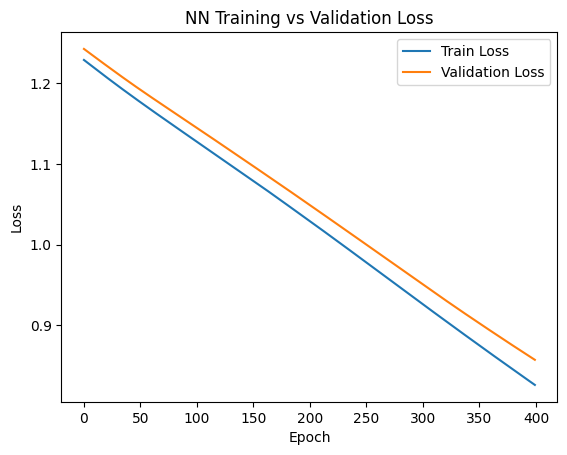

In [157]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("NN Training vs Validation Loss")
plt.legend()
plt.show()

In [158]:
model.eval()
with torch.no_grad():
    logits = model(X_val_t)
    probs = torch.sigmoid(logits)
    y_pred = (probs > 0.5).int().numpy().flatten()

nn_acc  = accuracy_score(y_val_np, y_pred)
nn_prec = precision_score(y_val_np, y_pred)
nn_rec  = recall_score(y_val_np, y_pred)
nn_f1   = f1_score(y_val_np, y_pred)

print("Neural Network:")
print("Accuracy:", nn_acc)
print("Precision:", nn_prec)
print("Recall:", nn_rec)
print("F1 Score:", nn_f1)

Neural Network:
Accuracy: 0.8771929824561403
Precision: 0.8918918918918919
Recall: 0.9166666666666666
F1 Score: 0.9041095890410958


# **Problem 3**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
from google.colab import drive

from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False
)

print("Training samples:", len(trainset))
print("Test samples:", len(testset))

100%|██████████| 170M/170M [00:04<00:00, 35.1MB/s]


Training samples: 50000
Test samples: 10000


In [7]:
class CIFAR10_FC(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CIFAR10_FC().to(device)
model

CIFAR10_FC(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    train_loss = train_one_epoch(model, trainloader, loss_fn, optimizer, device)
    test_acc = evaluate(model, testloader, device)

    epoch_time = time.time() - start_time

    print(f"Epoch {epoch}: time={epoch_time:.2f}s, loss={train_loss:.4f}, accuracy={test_acc:.2f}%")

Epoch 1: time=26.45s, loss=1.6476, accuracy=47.42%
Epoch 2: time=13.74s, loss=1.4396, accuracy=49.14%
Epoch 3: time=13.80s, loss=1.3538, accuracy=48.98%
Epoch 4: time=13.75s, loss=1.2774, accuracy=50.12%
Epoch 5: time=13.73s, loss=1.2150, accuracy=51.81%
Epoch 6: time=15.43s, loss=1.1530, accuracy=51.49%
Epoch 7: time=13.58s, loss=1.0981, accuracy=51.97%
Epoch 8: time=13.48s, loss=1.0465, accuracy=51.87%
Epoch 9: time=15.56s, loss=0.9772, accuracy=52.91%
Epoch 10: time=14.01s, loss=0.9298, accuracy=52.05%


In [10]:
# 3b

In [11]:
baseline_params = sum(p.numel() for p in model.parameters())
print("Baseline (1-hidden) params:", baseline_params)

Baseline (1-hidden) params: 1578506


In [12]:
class CIFAR10_FC_Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [13]:
model_deep = CIFAR10_FC_Deep().to(device)

loss_fn_deep = nn.CrossEntropyLoss()
optimizer_deep = optim.Adam(model_deep.parameters(), lr=0.001)

deep_params = sum(p.numel() for p in model_deep.parameters())
print("Deep (3-hidden) params:", deep_params)

Deep (3-hidden) params: 2103818


In [ ]:
EPOCHS = 300
total_time = 0.0
final_train_loss = None
final_test_acc = None

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    train_loss = train_one_epoch(model_deep, trainloader, loss_fn_deep, optimizer_deep, device)
    test_acc = evaluate(model_deep, testloader, device)

    epoch_time = time.time() - start_time
    total_time += epoch_time

    final_train_loss = train_loss
    final_test_acc = test_acc

    # You can print every epoch or every 10 epochs; I’d still do every epoch:
    print(f"Epoch {epoch}: time={epoch_time:.2f}s, loss={train_loss:.4f}, accuracy={test_acc:.2f}%")

print("\nAfter 300 epochs:")
print(f"Total training time: {total_time:.2f}s")
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final test accuracy: {final_test_acc:.2f}%")